In [44]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from custom import custom_funcs as cf
import random
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import cluster
from sklearn import metrics
import community

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
from notebook.services.config import ConfigManager
from IPython.paths import locate_profile
cm = ConfigManager(profile_dir=locate_profile(get_ipython().profile))
cm.update('livereveal', {
              'theme': 'solarized',
              'transition': 'linear',
              'start_slideshow_at': 'selected',
})
plt.rcParams['figure.figsize'] = (10, 8)

In [50]:
def draw_graph_with_node_colors(g, colors, pos=None, title="", with_labels=True, node_size=500):
    """ draw a graph with colored (literally, nothing to do with ps repr) nodes
    where the node colors are given by the list "colors"

     This is used to
     1. visualize the centrality measure of the nodes. it can very useful to draw the
     process communication graph and the color_graph with nodes colored by their centrality scales.

     2. visualize the partition/grouping in the context of the whole graph,
     by plotting each partition the same color that is different from the other partitions

    """
    plt.figure(figsize=(14, 11))
    plt.subplot(title=title)
    if not pos:
        pos = nx.spring_layout(g)

    nx.draw_networkx_edges(g, pos, alpha=0.5)
    nodes = nx.draw_networkx_nodes(g, pos, nodelist=g.nodes(),
                                   node_color=colors, cmap=plt.cm.rainbow, node_size=node_size)
    if with_labels:
        labels = dict(zip(g.nodes(), g.nodes()))
        nx.draw_networkx_labels(g, pos, labels, font_size=14)
    plt.colorbar(nodes, fraction=0.015, pad=0.02)
    plt.axis('off')
    plt.show()

# A Primer On Spectral Clustering

# What this is:

- Clustering: a very gentle overview 
- Spectral Clustering, intro and little demos
- A few other notable clustering/community detection algorithm based on graph theory
- For fun?
- This is not: A survey of clustering / spectral clustering / graph theory based clustering algorithms
- This does not cover: most of other clustering methods
- This does not deliver: any domain knowledge

# Clustering

- (Unsupervised) Divide data into groups (clusters) that are meaningful, useful or both 
    - We try to achieve these, but every so often, we get neither 
    - Internal (intra-cluster) homogeneity vs external (inter-cluster) heterogeneity  
    
- Applications
    - Explanatory analysis
    - Feature extracting
    - Dimension reduction



- Common clustering approaches, hierarchical vs partitioning
    - Hierarchical clustering
        - Agglomerative vs Divisive
    - Partitioning clustering
        - K-means
        - KNN

# Spectral Clustering 

- Easy to implement
- Reasonably fast
- Not too many assumptions


## Fast Forward: Basic Ideas

1. project your data into $R^{n}$
    
2. define an Affinity  matrix $A$ , using a Gaussian Kernel $K$ or say just an Adjacency matrix (i.e. $A_{i,j}=\delta_{i,j}$, or weighted adjacency matrix $W$)

3. construct the Graph Laplacian from $A$ or $W$ (i.e. decide on a normalization)

4. solve an Eigenvalue problem , such as $L v=\lambda v$  (or a Generalized Eigenvalue problem $L v=\lambda D v$ )

5. select $k$ eigenvectors $\{ v_{i}, i=1, \dots, k \}$ corresponding to the $k$ lowest (or highest) eigenvalues $\{ \lambda_{i}, i=1,\dots, k \}$, to define $k$-dimensional subspace $P^{T}LP$

6. form clusters in this subspace using, say, k-means

# A more careful look at this ...

# Step-by-Step with Python
- NetworkX
- Numpy, Pandas, Jupyter, scikit-learn, matplotlib

<class 'networkx.classes.graph.Graph'>


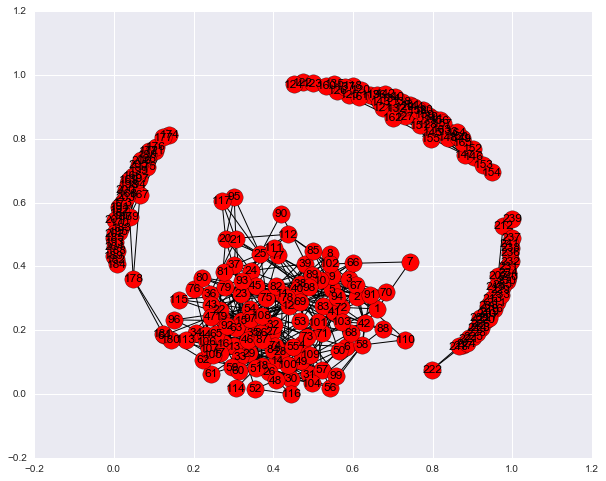

In [4]:
G = cf.load_physicians_network()
print type(G)
G.number_of_nodes(), G.number_of_edges()
nx.draw_networkx(G)

## Pre-processing
- Select features, choose affinity measures, properly construct the graph

## Spectral analysis and projections
- Determine right matrix forms, solve eigenvalue problems, 
- Projection into lower dimension eigenspaces

## Clustering
- conventional clustering in lower dimensional spaces with clustering features are more pronounced

# Pre-processing


# Proximity Measures 

$$ G = (V, E) $$

## Space vs Graph View of Data

- Fully connected graph
- Neighborhood graphs
- Or just graphs (my case)

## Distance and/vs Affinity


# Graphs ARE Matrices 
         - btw: This can be personal

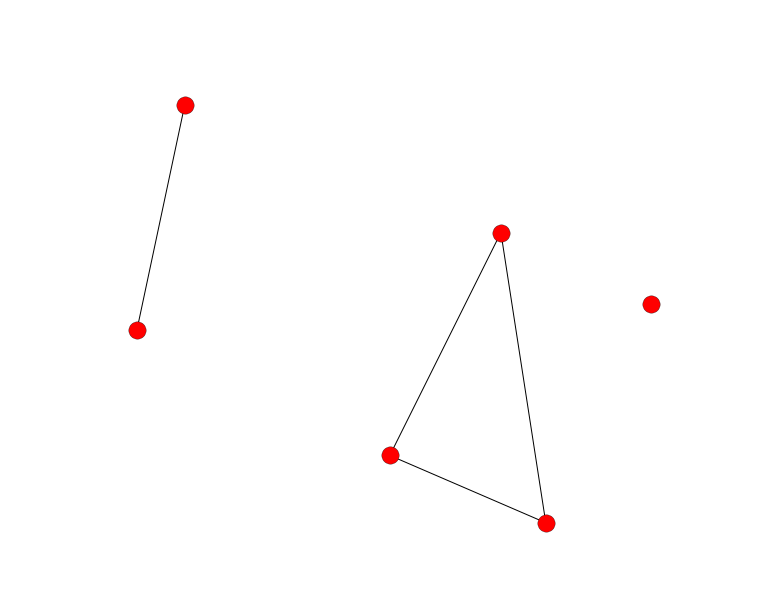

In [5]:
G = nx.Graph()
G.add_nodes_from(range(6))
G.add_edges_from([(0,1),(1,2), (0,2), (3, 4)])
nx.draw_spring(G)

## (Weighted) Adjacency Matrix
- edge weight $w_{ij} \geq 0$.
- weighted matrix $ W = [w_{ij}]$
- simple adjacency matrix $A$

## Degree Matrix 
- node degree $d_i = \sum_{j=1}^n w_{ij}$
- degree matrix - diagonal matrix of $[d_i]$

In [6]:
# Computing degree matrix
D = np.diag(G.degree(G.nodes()).values())
D = pd.DataFrame(D)
print D

   0  1  2  3  4  5
0  2  0  0  0  0  0
1  0  2  0  0  0  0
2  0  0  2  0  0  0
3  0  0  0  1  0  0
4  0  0  0  0  1  0
5  0  0  0  0  0  0


In [7]:
# Computing Laplacian, degree matrix, and adjacency matrix in networkx
W = nx.adjacency_matrix(G).todense()
W = pd.DataFrame(W)
print W

   0  1  2  3  4  5
0  0  1  1  0  0  0
1  1  0  1  0  0  0
2  1  1  0  0  0  0
3  0  0  0  0  1  0
4  0  0  0  1  0  0
5  0  0  0  0  0  0


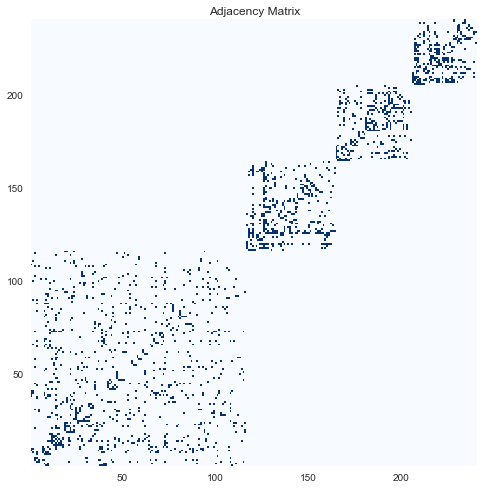

In [8]:
G1 = cf.load_physicians_network()
matrix = nx.to_numpy_matrix(G1)

plt.pcolor(np.array(matrix), cmap='Blues')
plt.axes().set_aspect('equal') # set aspect ratio equal to get a square visualization
plt.xlim(min(G1.nodes()), max(G1.nodes())) # set x and y limits to the number of nodes present.
plt.ylim(min(G1.nodes()), max(G1.nodes()))
plt.title('Adjacency Matrix')
plt.show()


## The Laplacians

- unnormalizaed Laplacian
$$ L \triangleq D - W $$



- normalized Laplacian
 $$ 
 \begin{align} L_{sym} &\triangleq D^{-1/2} W D^{-1/2}  \nonumber \\
 &= I - D^{-1/2}W D^{-1/2} \nonumber \\
 L_{rw} &\triangleq D^{-1} L \nonumber \\
 \end{align}
 $$
 
- Relaxed Laplacian
$$
  L_\rho= L - \rho D 
$$

- Others
$$
    \begin{align}
    L_{njw} &= D^{-1/2} W D^{-1/2}, \text{with } W_{i,i} = 0 \nonumber\\
    \end{align}
$$

In [9]:
# Computing Laplacian, degree matrix, and adjacency matrix in networkx
L = np.array(nx.laplacian_matrix(G).todense())
W = nx.adjacency_matrix(G).todense()
D = np.diag(G.degree(G.nodes()).values())
L, W, D = pd.DataFrame(L), pd.DataFrame(W), pd.DataFrame(D)
print L

   0  1  2  3  4  5
0  2 -1 -1  0  0  0
1 -1  2 -1  0  0  0
2 -1 -1  2  0  0  0
3  0  0  0  1 -1  0
4  0  0  0 -1  1  0
5  0  0  0  0  0  0


## Matrices as Features?
- General space distance to affinity measures?
    - Euclidean, Minkowski Distance
    - Gaussian Kernels (similarity = np.exp(-beta * distance / distance.std())
    - Hamming? 
    - Levenshtein? By the way, how do you computer Levenshtein distance?
    - Relative Entropy? Mutual Information?

# Spectral analysis and projections

## Laplacians:      A Spectral Graph Theory Perspective




## Properties of Laplacians

- Symmetric and positive semi-definite

- Smallest eigenvalue $0$ corresponding to all $1$ eigenvector

- Multiplicity $k$ of $0$ eigenvalue corresponding to number of connected components

- Similar details for unnormalized ($L$) or normalized Laplacians ($L_{sys}$ and $L_{rw}$)

In [10]:
eigenvalues, eigenvectors = np.linalg.eig(L)
print ("Number of disconnected components: {}".format(len(eigenvalues[eigenvalues < 1e-10])))
print ("Corresponding eigenvectors:")
print pd.DataFrame(eigenvectors[:, eigenvalues < 1e-12])

Number of disconnected components: 3
Corresponding eigenvectors:
         0         1    2
0 -0.57735  0.000000  0.0
1 -0.57735  0.000000  0.0
2 -0.57735  0.000000  0.0
3  0.00000  0.707107  0.0
4  0.00000  0.707107  0.0
5  0.00000  0.000000  1.0


In [11]:
G = cf.load_physicians_network()
L = np.array(nx.laplacian_matrix(G).todense())
eigenvalues, eigenvectors = np.linalg.eig(L)
print ("Number of disconnected components: {}".format(len(eigenvalues[eigenvalues < 1e-10])))

Number of disconnected components: 4


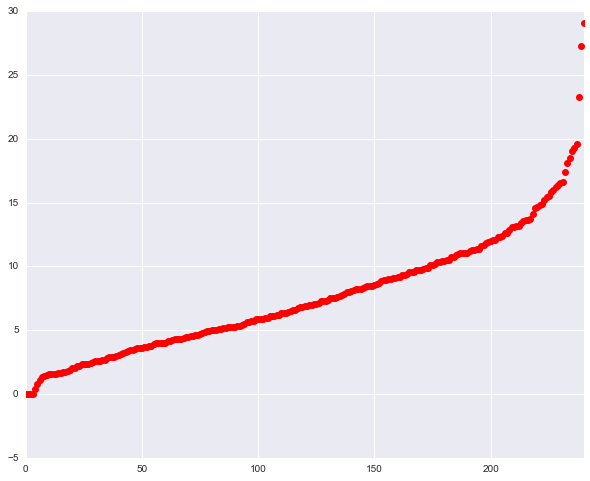

In [12]:
pd.Series(sorted(eigenvalues)).plot(style='ro ')

## Useful formulations

- Relaxations of min-cut optimizations (more on this later)

# Clustering

- Possibly the simplest part
- k-means are most commonly used, but somewhat arbitrary
- euclidean distance 

# So why on earth it works?

# Interpretations: Graph Partitioning

# Graph cuts 
- pretty much center of my universe for a long time
- some side notes

For $A \subseteq V$, 
- $|A|$: cardinality of $A$
- $\text{Vol}(A) = \sum_{i \in A} d_i$

## Cuts (2-way, k-way)

$$ 
\begin{align*}
\text{Cut} (A, B) &=  \sum_{i\in A, j \in B} w_{ij}~, \\
\text{Cut} (A_1, \cdots, A_k) &= \frac{1}{2} \sum_i^k \text{cut}(A_i, \overline{A_i}) 
\end{align*}
$$

- May not be very effective. Why?


## Ratio Cuts

$$
\begin{align*}
\text{RatioCut} (A, B) &= \text{Cut} (A, B) \left(\frac{1}{|A|} + \frac{1}{|B|}\right)~, \\
\text{RatioCut} (A_1, \cdots, A_k) &= \frac{1}{2} \sum_i^k \frac{\text{cut}(A_i, \overline{A_i})}{|A_i|}
\end{align*}
$$




## Normalized Cuts

$$ 
\begin{align*}
\text{NCut} (A, B) &= \text{Cut} (A, B) \left(\frac{1}{\text{Vol}(A)} + \frac{1}{\text{Vol}(|B|)}\right)~, \\
\text{NCut} (A_1, \cdots, A_k) &= \frac{1}{2} \sum_i^k \frac{\text{cut}(A_i, \overline{A_i})}{\text{Vol}(A_i)}
\end{align*}
$$

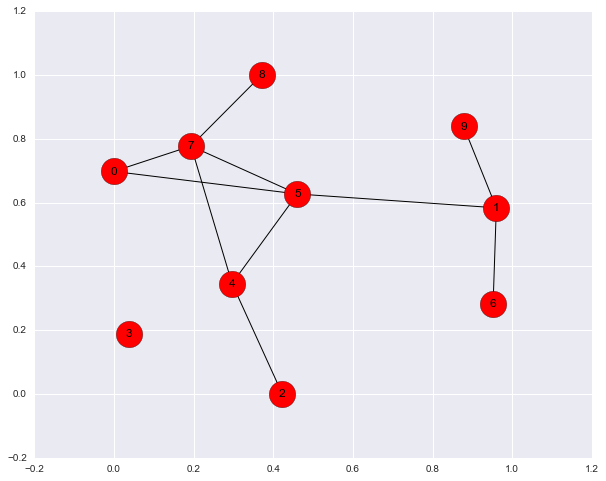

In [13]:
G = nx.fast_gnp_random_graph(10, 0.2)
nx.draw_networkx(G, node_size=700)

## k-way cut minimizations

$H = [h_j]$ normalized indicator matrix in $\mathbb{R}^{n \times k}$ for cluster membership,
$$
    \text{RatioCut}(A_1, \cdots, A_k) = \sum_{i=1}^k h_i^T L h_i = \text{Tr}(H^T L H)
$$

- Why does this lead to good clustering? 

## k-way cut minimizations
$$
\begin{align*}
\min_{A_1, ..., A_k} \text{Tr}(H^T L H) \\
\text{s. t.} \qquad H^T H = I
\end{align*}
$$


- Difficult optimization problems
- From min-cut relaxation to spectral clustering, relaxation:
    - From $A_i, i=1, \cdots k$,
    - To $H\in \mathbb{R}^{n\times k}$
- Rayleigh-Ritz

# Interpretations: Random Walk $L_{rw}$

## Transition matrix $P$
$$
    P = D^{-1} W
$$

## Random Walk and Ncut
$$
    \text{Ncut} (A, \overline{A}) = P(\overline{A}|A) + P(A|\overline{A})
$$

- So why does it matter to minimize Normalized Cuts?
- Minimize Ncut <=> minimize inter-cluster transitions

# Parameter Tuning and Evaluation

## Choose the cluster number

- Domain knowledge, manually set number of clusters

- Eigengaps detection

/Users/weifei/.virtualenvs/pydata/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


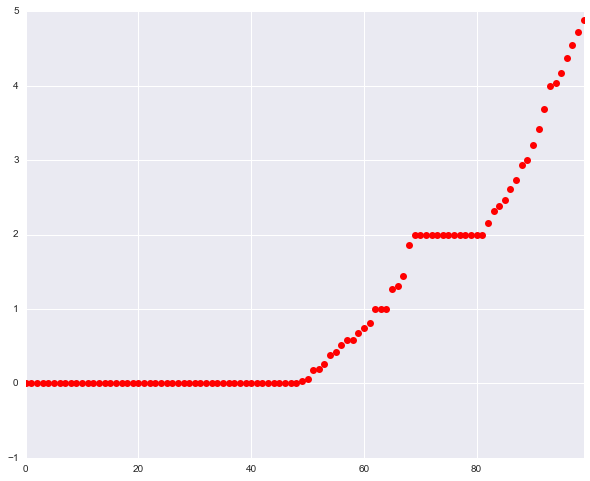

In [22]:
G_random = nx.erdos_renyi_graph(100, 0.01)
L = np.array(nx.laplacian_matrix(G_random).todense())
eigenvalues, eigenvectors = np.linalg.eig(L)
pd.Series(sorted(eigenvalues)).plot(style='ro ')

## Evaluation: 

- With Ground Truth

- Without Ground Truth

# An Example?

In [23]:
file_name = "./datasets/ps_cmd/ps_cmd.csv"
ps_cmd = pd.read_csv(file_name,header=None)
ps_cmd.columns = ['cmd']

In [24]:
ps_cmd['cmd'].sample(10)

31899                                           rpc.mountd
82602    /oracle/product/11.2.0.3/CMWPRD/bin/tnslsnr LI...
19126    pe7796 -P17796 -U.PERTI.17796 -F/usr/SD/ert/tm...
79606             /oracle/product/grid_home/bin/ocssd.bin 
24333    pe7798 -P17798 -U.PERTI.17798 -F/usr/SD/ert/tm...
66287    FNDLIBR                                       ...
29204    /apps/csfstg/apps/tech_st/10.1.3/appsutil/jdk/...
20190              /oracle/product/grid_home/bin/gipcd.bin
12309       /oracle/product/grid_home/bin/ohasd.bin reboot
54302    /opt/httpd/cdcapp-prod3-101/httpd-prod_xxappmg...
Name: cmd, dtype: object

In [25]:
ps_cmd["cmd_terms"] = ps_cmd.cmd.str.lower()
ps_cmd["cmd_terms"] = [re.sub(u'\d', "", x) for x in ps_cmd['cmd_terms']]
ps_cmd['cmd_terms'] = [re.sub(u'([^\w\.]|_)', ' ', x).strip() for x in ps_cmd['cmd_terms']]
ps_cmd = ps_cmd.sample(5000)

In [26]:
params = {"analyzer":"word", "min_df":1, "ngram_range":(1,1), "norm":"l2"}
TfidfVect = TfidfVectorizer(**params)
ps_dtm = TfidfVect.fit_transform(ps_cmd['cmd_terms'])

In [27]:
ps_dtm_cos_similarity = metrics.pairwise.cosine_similarity(ps_dtm)

In [28]:
cluster_ids = cluster.spectral_clustering(affinity=ps_dtm_cos_similarity)
ps_cmd['cluster'] = cluster_ids

/Users/weifei/.virtualenvs/pydata/lib/python2.7/site-packages/sklearn/manifold/spectral_embedding_.py:217: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [29]:
cmd_clusters = ps_cmd.groupby('cluster')['cmd']

# Let's switch gears a bit

## Recall the "cut" interpretation
- Cuts are simply some objective functions
- So why "cut"? why not some other measures? 
- what are other objective functions? what's a good measure?
    - reflect intra-cluster similarity and inter-cluster difference
- densities

# Hierarchical Clustering Heuristics

- spectral clustering is partition-based. How about hierarchical methods?
- community detection 
    - yes, people just like different names, don't they?

# Graph Modularity and Community Detections

## Graph Modularity 

$$ {\displaystyle Q={\frac {1}{(2m)}}\sum _{vw}\left[A_{vw}-{\frac {k_{v}k_{w}}{(2m)}}\right]\delta (c_{v},c_{w})=\sum _{i=1}^{c}(e_{ii}-a_{i}^{2})}$$

- $m$: |E|
- $c_v$: cluster of node $v$
- $k_v$: degree of $v$



- How do we interpret this?


In [30]:
def modularity(graph, partition, weight='weight'):
    if type(graph) != nx.Graph:
        graph = graph.to_directed()

    # deal with different partition inputs
    # 1. map from each node to it's partition id.
    # 2. map from partition id to list of node ids
    # unify input into the second kind
    first_key = partition.keys()[0]
    if isinstance(partition[first_key], Iterable):
        # second type, do conversion
        partition = pd.Series(dict([(node, part) for part in partition.keys()
                                    for node in partition[part]]))

    if type(partition) == pd.Series:
        partition = partition.to_dict()

    inc = dict([])
    deg = dict([])
    links = graph.size(weight=weight)
    if links == 0:
        raise ValueError("A graph without link has an undefined modularity")

    for node in graph:
        com = partition[node]
        deg[com] = deg.get(com, 0.) + graph.degree(node, weight=weight)
        for neighbor, datas in graph[node].items():
            edge_weight = datas.get(weight, 1)
            if partition[neighbor] == com:
                if neighbor == node:
                    inc[com] = inc.get(com, 0.) + float(edge_weight)
                else:
                    inc[com] = inc.get(com, 0.) + float(edge_weight) / 2.

    res = 0.
    for com in set(partition.values()):
        res += (inc.get(com, 0.) / links) - (deg.get(com, 0.) / (2. * links)) ** 2
    return res

## Graph Centralities and Divisive Algorithms

## Centrality of nodes and edges

- why centrality matters?
- centrality metrics (http://networkx.readthedocs.io/en/stable/reference/algorithms.centrality.html)
    - degree
    - betweenness
    - Katz centrality and PageRank

In [37]:
G = cf.load_seventh_grader_network()
print G.number_of_nodes(), G.number_of_edges()
print pd.Series(nx.betweenness_centrality(G)).sort_values()

29 376
18    0.000000
14    0.003545
28    0.005242
15    0.006147
1     0.007114
19    0.007289
7     0.008696
17    0.008727
29    0.009319
20    0.009528
23    0.009665
12    0.011731
13    0.012536
26    0.013924
27    0.014461
10    0.015491
8     0.016419
4     0.018895
11    0.020509
24    0.022722
21    0.023300
25    0.029328
3     0.031818
22    0.036250
16    0.041366
2     0.041671
9     0.043783
5     0.078779
6     0.098574
dtype: float64


In [38]:
G = nx.erdos_renyi_graph(50, 0.13)
pos = nx.spring_layout(G)

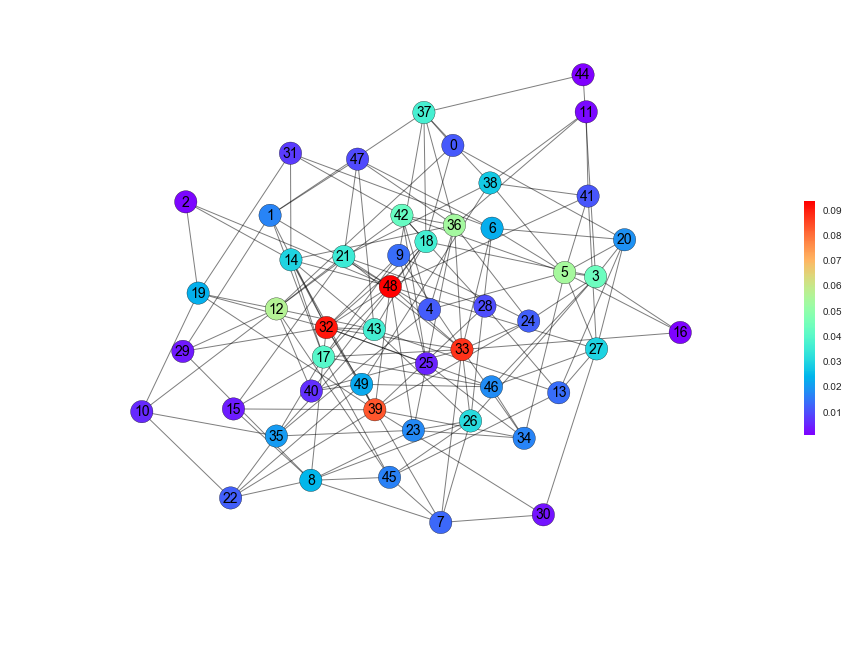

In [39]:
centralities = pd.Series(nx.betweenness_centrality(G))
draw_graph_with_node_colors(G, centralities, pos=pos)

In [ ]:
centralities = pd.Series(nx.degree_centrality(G))
draw_graph_with_node_colors(G, centralities, pos=pos)

## Girvan-Newman Algorithm
1. remove high betweenness (or other centrality metrics) edges
2. compute connected components
3. check modularity, back to step 1

## Agglomerative Algorithms

## Louvain

1. Each node assigned its own community, compute the modularity
2. Test for each node and its neighbor node  if removing  and combining it into the community of  increases the modularity of the graph. The change of modularity under such action is 
$\Delta Q={\bigg [}{\frac {\Sigma _{in}+k_{i,in}}{2m}}-{\bigg (}{\frac {\Sigma _{tot}+k_{i}}{2m}}{\bigg )}^{2}{\bigg ]}-{\bigg [}{\frac {\Sigma _{in}}{2m}}-{\bigg (}{\frac {\Sigma _{tot}}{2m}}{\bigg )}^{2}-{\bigg (}{\frac {k_{i}}{2m}}{\bigg )}^{2}{\bigg ]}$

	If the change is positive, move  into the community of 
3. Iterate step 2 for all pairs until no more increase in modularity is possible
4. Combine all node in each community to form a super node for each graph, iterate step 1-4 on the super node graph.


In [54]:
G = cf.load_sociopatterns_network()
print G.number_of_edges(), G.number_of_nodes()
pos = nx.spring_layout(G)

2765 410


In [47]:
partitions = pd.Series(community.best_partition(G))

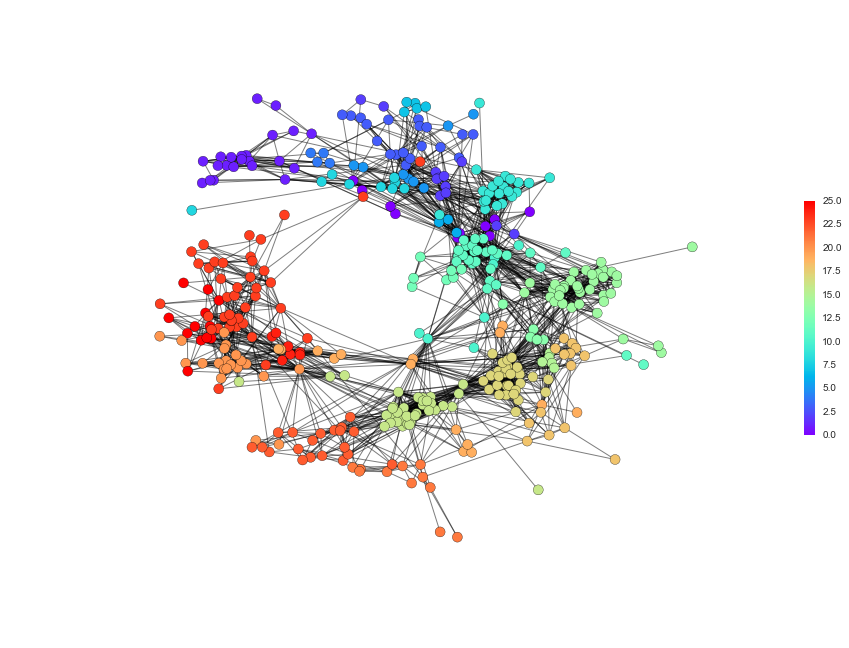

In [51]:
draw_graph_with_node_colors(G, partitions, pos=pos, with_labels=False, node_size=100)

In [55]:
G = cf.load_physicians_network()
print G.number_of_edges(), G.number_of_nodes()
pos = nx.spring_layout(G)

923 241


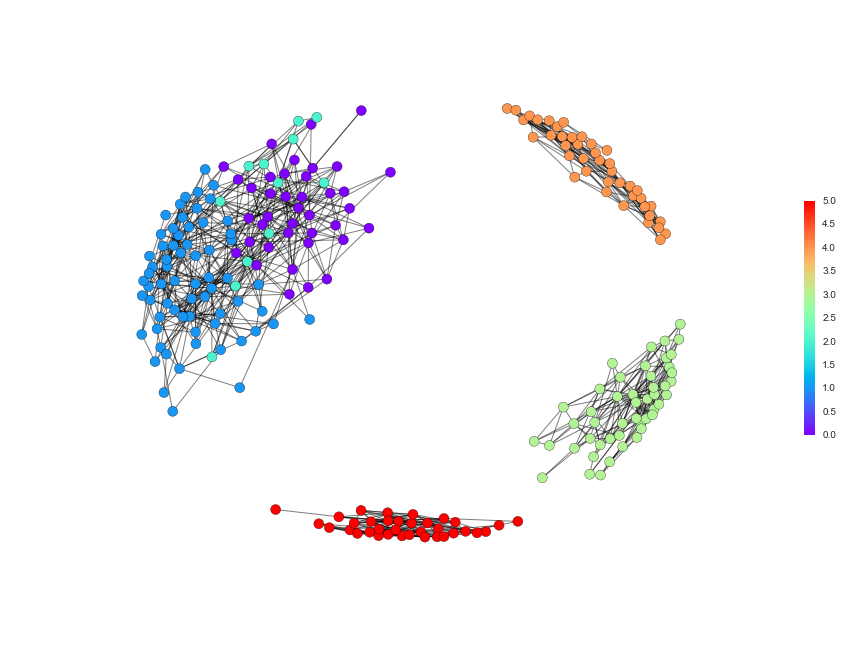

In [56]:
partitions = pd.Series(community.best_partition(G))
draw_graph_with_node_colors(G, partitions, pos=pos, with_labels=False, node_size=100)

# Thanks, and so, what's next ?!

# References
[1] D. Xu and Y. Tian, “A Comprehensive Survey of Clustering Algorithms,” Ann. Data. Sci., vol. 2, no. 2, pp. 165–193, Aug. 2015.

[2] U. Von Luxburg, “A tutorial on spectral clustering,” Statistics and computing, vol. 17, no. 4, pp. 395–416, 2007.

[3] A. Y. Ng, M. I. Jordan, Y. Weiss, and others, “On spectral clustering: Analysis and an algorithm,” Advances in neural information processing systems, vol. 2, pp. 849–856, 2002.

[4] F. Jordan and F. Bach, “Learning spectral clustering,” Adv. Neural Inf. Process. Syst, vol. 16, pp. 305–312, 2004.

[5] T. Xiang and S. Gong, “Spectral clustering with eigenvector selection,” Pattern Recognition, vol. 41, no. 3, pp. 1012–1029, 2008.

[6] “Spectral Clustering, ICML 2004 Tutorial by Chris Ding.” [Online]. Available: http://ranger.uta.edu/~chqding/Spectral/.

[7] S. Fortunato, “Community detection in graphs,” Physics Reports, vol. 486, no. 3–5, pp. 75–174, Feb. 2010.

[8] M. Girvan and M. E. Newman, “Community structure in social and biological networks,” Proceedings of the national academy of sciences, vol. 99, no. 12, pp. 7821–7826, 2002.

[9] M. E. Newman and M. Girvan, “Finding and evaluating community structure in networks,” Physical review E, vol. 69, no. 2, p. 26113, 2004.

[10] V. D. Blondel, J.-L. Guillaume, R. Lambiotte, and E. Lefebvre, “Fast unfolding of communities in large networks,” Journal of statistical mechanics: theory and experiment, vol. 2008, no. 10, p. P10008, 2008.

[11] Clustering using Scikit-Learn: http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering






